In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import List, Tuple, Optional

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

plt.rcParams["figure.figsize"]= 14, 14
sns.set_theme(style="darkgrid")

def set_plot_size(ax, size=20) -> None:
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	    label.set_fontsize(size)


def plot(frame: pd.DataFrame, title: str, xlabel: str, ylabel: str, size=20, plot_type=sns.scatterplot) -> None:
    ax = plot_type(data=frame, x=xlabel, y=ylabel)
    ax.set_title(title, fontsize=size)
    ax.set_ylabel(ylabel, fontsize=size)
    ax.set_xlabel(xlabel, fontsize=size)
    
    set_plot_size(ax, size)

## Признаки (столбцы фрейма):
1. `satisfaction_level` - Уровень удовлетворенности работой
1. `Last_evaluations` - Время с момента последней оценки в годах
1. `number_projects` - Количество проектов, выполненных за время работы
1. `average_monthly_hours` - Среднее количество часов на рабочем месте в месяц
1. `time_spend_company` - Стаж работы в компании в годах
1. `work_accident` - Происходили ли несчастные случаи на рабочем месте с сотрудником
1. `left` - уволился ли сотрудник
1. `promotion_last_5years` - повышался ли сотрудник за последние пять лет
1. `department` - отдел в котором работает сотрудник
1. `salary` - относительный уровень зарплаты

## 1. Извлечение фрейма

In [6]:
hr_frame = pd.read_csv("./HR.csv")
hr_frame.info() # фантастика!!! нет пустых данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [2]:
hr_frame.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 2. Основные статистики

In [94]:
def salary_to_number(salary_type: str) -> int:
    if salary_type.lower() == "low":
        return 1
    if salary_type.lower() == "medium":
        return 2
    if salary_type.lower() == "high":
        return 3
    return 0

#добавить столбец для численного обозначения уровня зарплат
hr_frame["salary_number"] = hr_frame["salary"].apply(salary_to_number)

# понятно, что mean и std для категориальных не имеет смысла, но так быстрее сразу весь фрейм обработать
main_statistic = hr_frame.agg(['min', 'max', 'median', 'mean', lambda x: x.mode()[0], 'std'])
main_statistic = main_statistic.rename(index={"<lambda>": "mode"})
main_statistic

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,salary_number
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,IT,high,1.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,technical,medium,3.000000
median,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN,2.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN,1.594706
mode,0.100000,0.550000,4.000000,135.000000,3.000000,0.000000,0.000000,0.000000,sales,low,1.000000
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN,0.637183


## 3. Корреляционный анализ

In [98]:
def most_correlation_columns(cor_tables: List[pd.DataFrame], columns_names: List[str], reverse=True, return_count=2) -> dict:
    columns_cor_value = {}

    for column_name in columns_names:
        for row_name in columns_names:
            if column_name == row_name:
                continue

            # убрать зеркальные
            if (column_name, row_name) in columns_cor_value:
                continue

            columns_cor_value[(row_name, column_name)] = 0

    for table in cor_tables:
        for row_name, column_name in columns_cor_value:
            columns_cor_value[(row_name, column_name)] += table[row_name][column_name]

    columns_cor_value = sorted([(k, v) for k, v in columns_cor_value.items()], key=lambda x: abs(x[1]), reverse=reverse)

    # значение это среднее по списку корреляционных таблиц
    return {names: value / len(cor_tables)  for names, value in columns_cor_value[:return_count]}


In [61]:
# Пирсон
pearson_cor = hr_frame.corr()
pearson_cor

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_number
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605,0.050022
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684,-0.013002
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064,-0.001803
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544,-0.002242
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433,0.048715
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245,0.009247
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788,-0.157898
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000,0.098119
salary_number,0.050022,-0.013002,-0.001803,-0.002242,0.048715,0.009247,-0.157898,0.098119,1.000000


In [58]:
# Спирман
spearma_cor = hr_frame.corr(method='spearman')
spearma_cor

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_number
satisfaction_level,1.000000,0.162407,0.005786,0.062000,-0.139428,0.056333,-0.365842,0.022306,0.045381
last_evaluation,0.162407,1.000000,0.350399,0.342061,0.161154,-0.005767,-0.002440,-0.007167,-0.009117
number_project,0.005786,0.350399,1.000000,0.397855,0.251971,0.002328,-0.019544,-0.002960,0.004453
average_montly_hours,0.062000,0.342061,0.397855,1.000000,0.168750,-0.006063,0.046455,-0.002951,0.002452
time_spend_company,-0.139428,0.161154,0.251971,0.168750,1.000000,-0.027277,0.268876,0.035205,0.001274
Work_accident,0.056333,-0.005767,0.002328,-0.006063,-0.027277,1.000000,-0.154622,0.039245,0.008496
left,-0.365842,-0.002440,-0.019544,0.046455,0.268876,-0.154622,1.000000,-0.061788,-0.152266
promotion_last_5years,0.022306,-0.007167,-0.002960,-0.002951,0.035205,0.039245,-0.061788,1.000000,0.094273
salary_number,0.045381,-0.009117,0.004453,0.002452,0.001274,0.008496,-0.152266,0.094273,1.000000


In [96]:
# самые скореллированные столбцы. Суммарно по 2-м критериям
most_correlation_columns([pearson_cor, spearma_cor], list(pearson_cor))

{('average_montly_hours', 'number_project'): 0.4075329158871812,
 ('left', 'satisfaction_level'): -0.3771086104217912}

In [97]:
# наименее скореллированные столбцы. Суммарно по 2-м критериям
most_correlation_columns([pearson_cor, spearma_cor], list(pearson_cor), reverse=False)

{('salary_number', 'average_montly_hours'): 0.0001050007559746833,
 ('Work_accident', 'number_project'): -0.0012064617534937785}

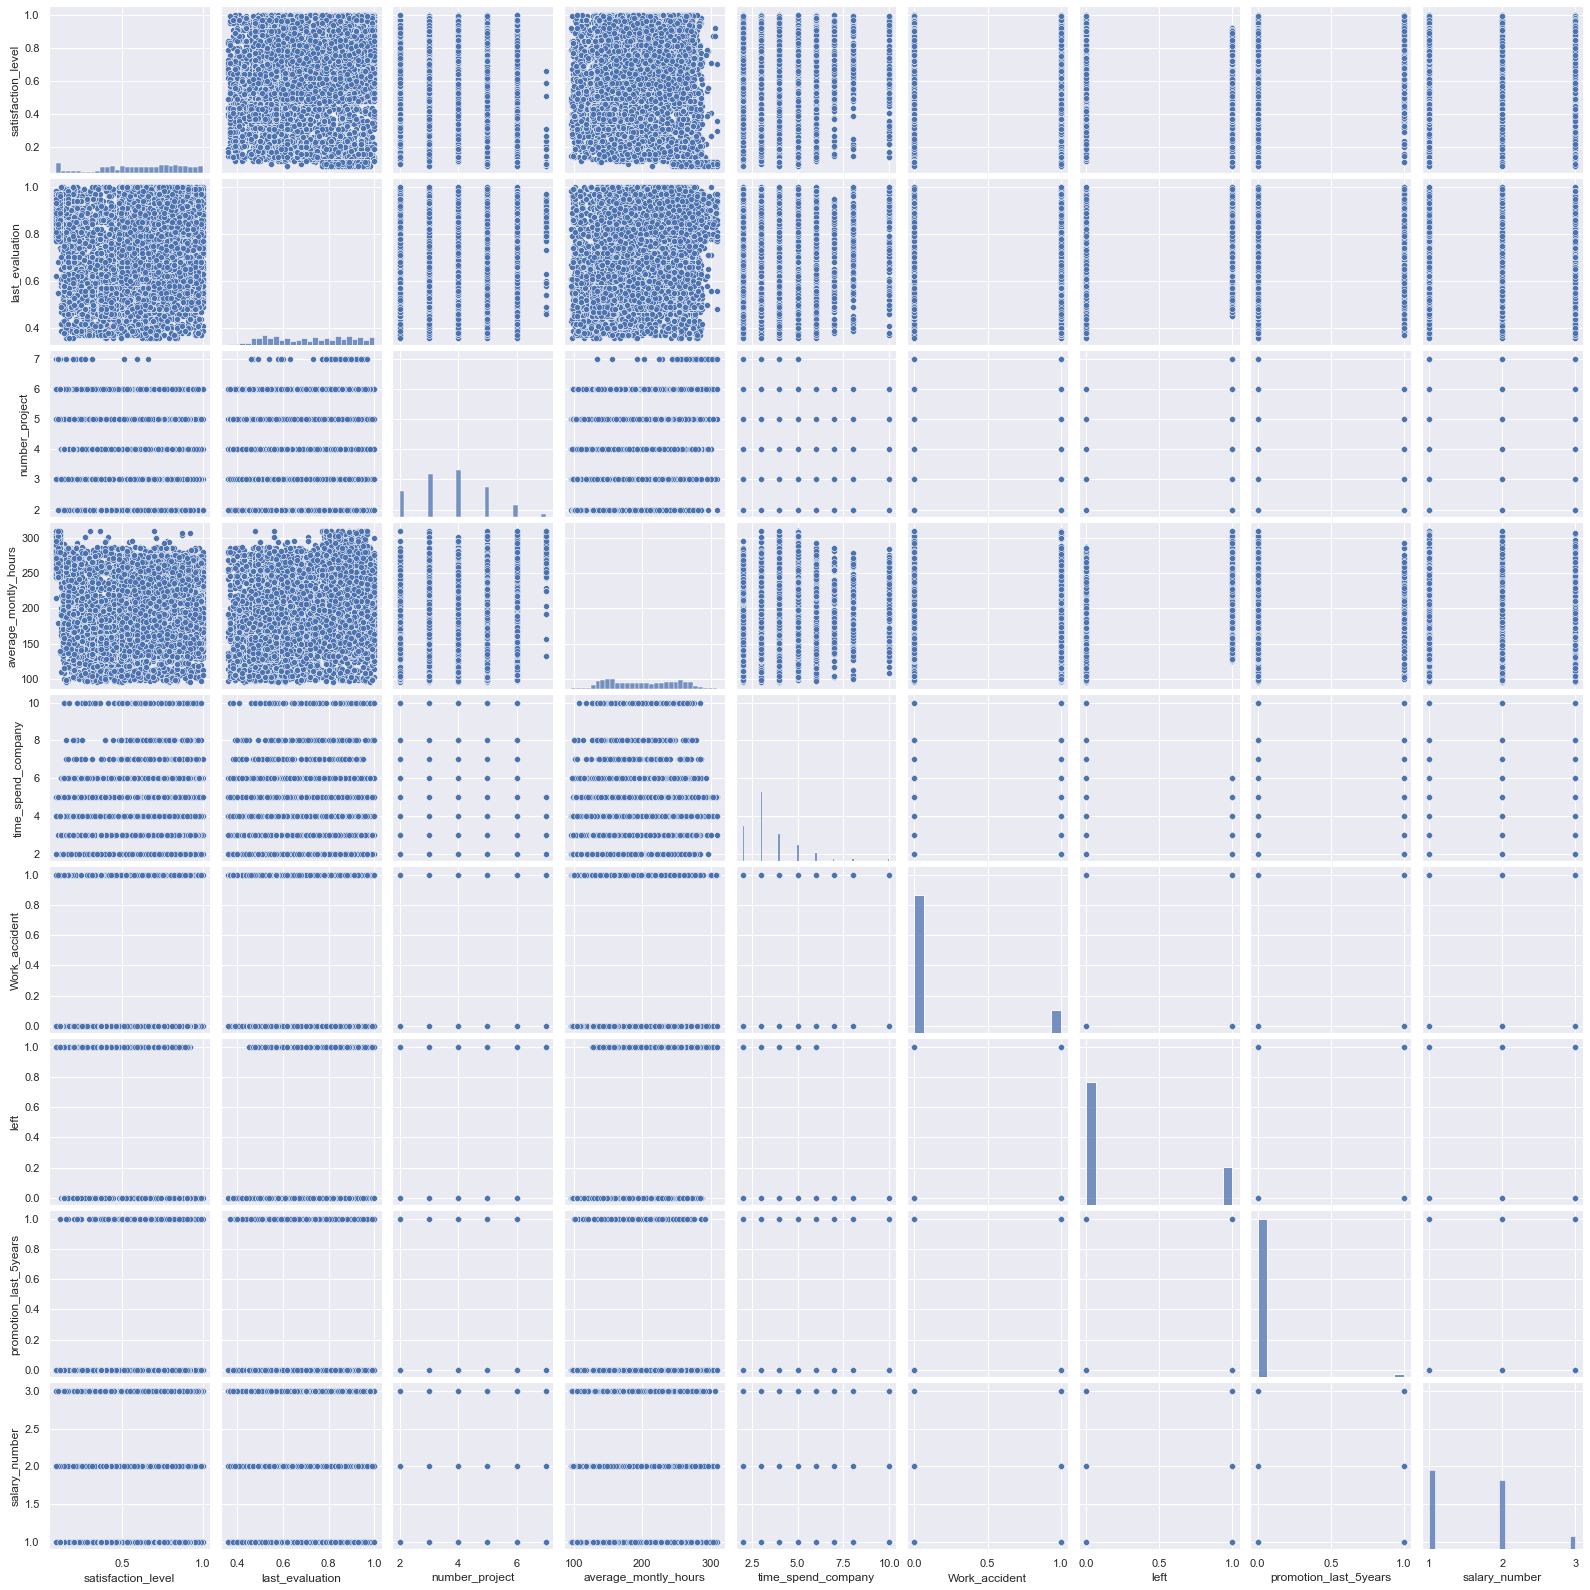

In [124]:
sns.pairplot(hr_frame)

## 4. Число сотрудников по отделам

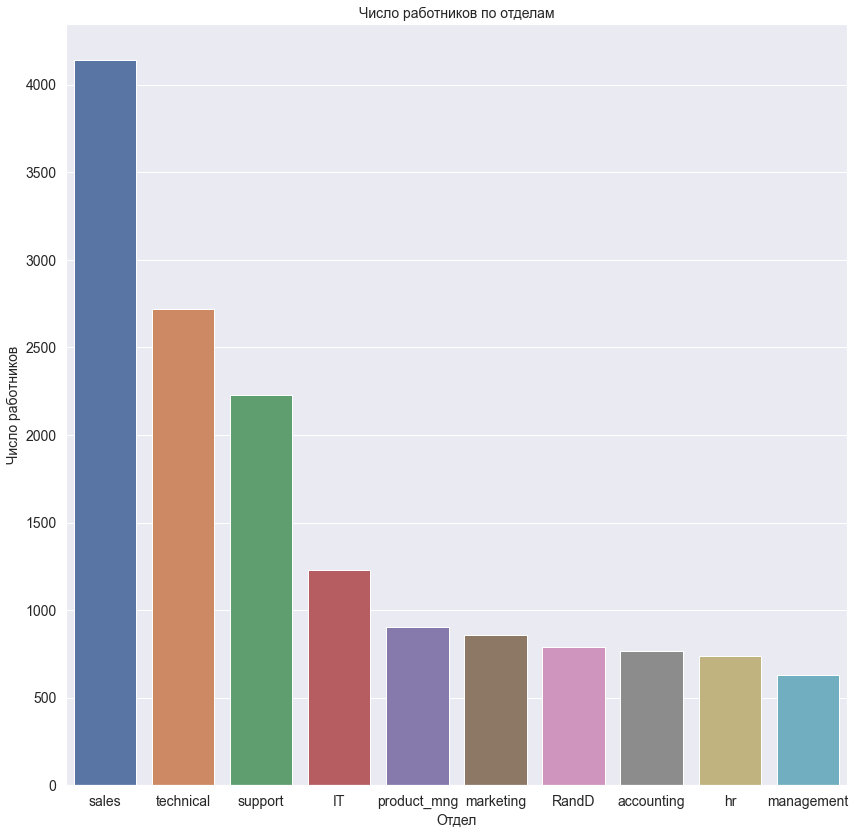

In [129]:
departments_count = pd.DataFrame(hr_frame["department"].value_counts().reset_index())
departments_count = departments_count.rename(columns={"index": "Отдел", "department": "Число работников"})

plot(departments_count, "Число работников по отделам", "Отдел", "Число работников", size=14, plot_type=sns.barplot)

## 5. Распределение сотрудников по зарплатам

In [143]:
def plot_salary_sample(frame: pd.DataFrame, title: str, column_name=None, column_value=None) -> None:
    if column_name is None:
        employees_count = pd.DataFrame(hr_frame["salary"].value_counts().reset_index())
    else:
        employees_count = hr_frame.loc[hr_frame[column_name] == column_value]
        employees_count = pd.DataFrame(employees_count["salary"].value_counts().reset_index())
    
    employees_count = employees_count.rename(columns={"index": "Уровень зарплаты", "salary": "Число работников"})

    plot(employees_count, title, "Уровень зарплаты", "Число работников", plot_type=sns.barplot)


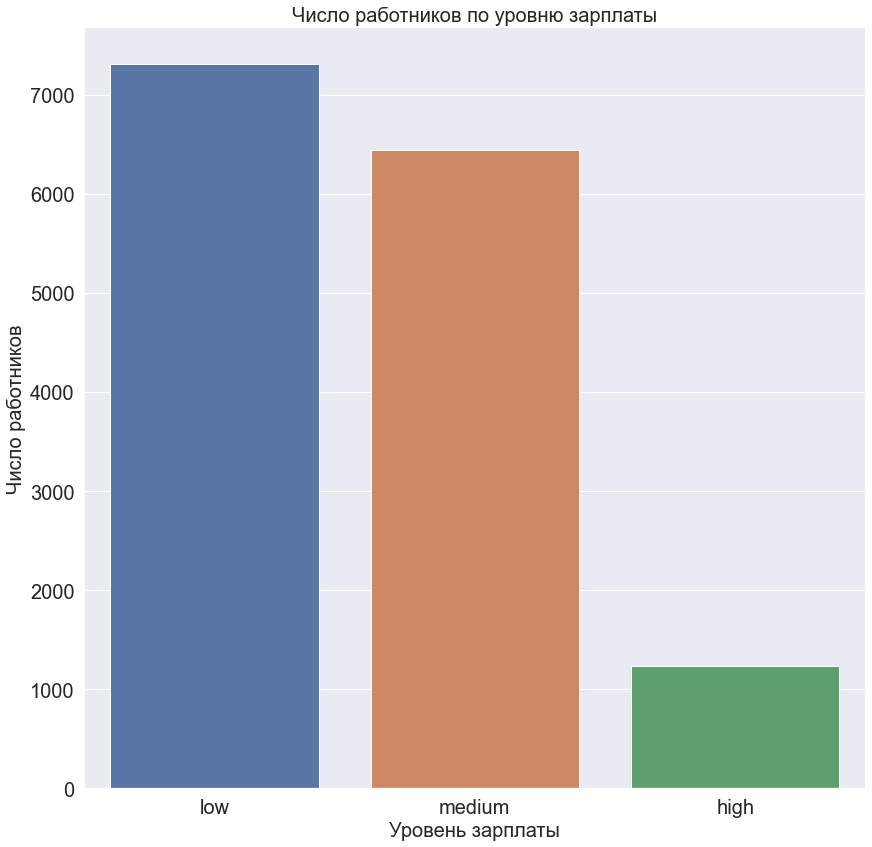

In [145]:
plot_salary_sample(hr_frame, "Число работников по уровню зарплаты")

## 6. Распределение сотрудников по зарплатам для каждого отдела

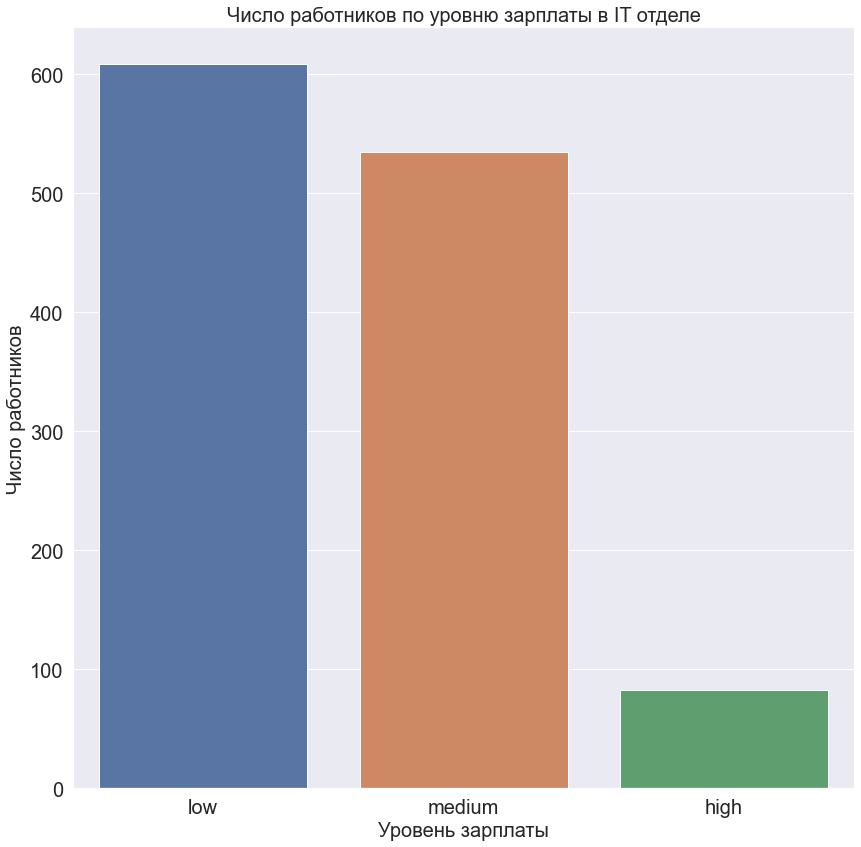

In [146]:
# чтобы не делать все графики. Приведу парочку (можно будет добавить вызовов функции)
plot_salary_sample(hr_frame, "Число работников по уровню зарплаты в IT отделе", "department", "IT")

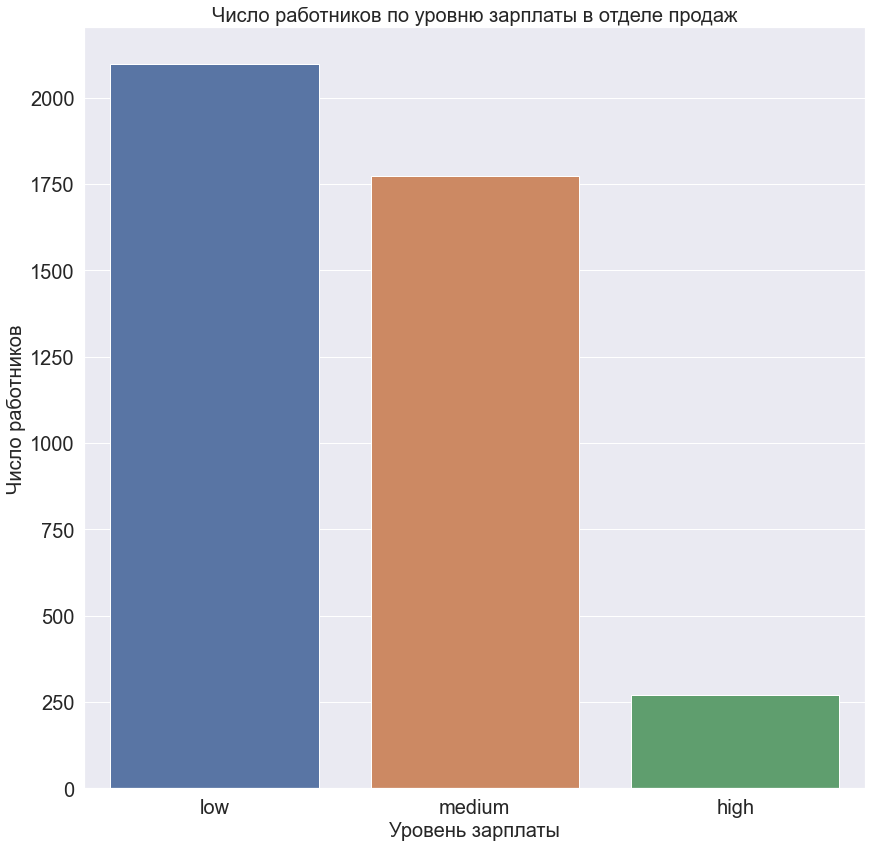

In [147]:
plot_salary_sample(hr_frame, "Число работников по уровню зарплаты в отделе продаж", "department", "sales")

## 7. Проверка гипотезы, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом

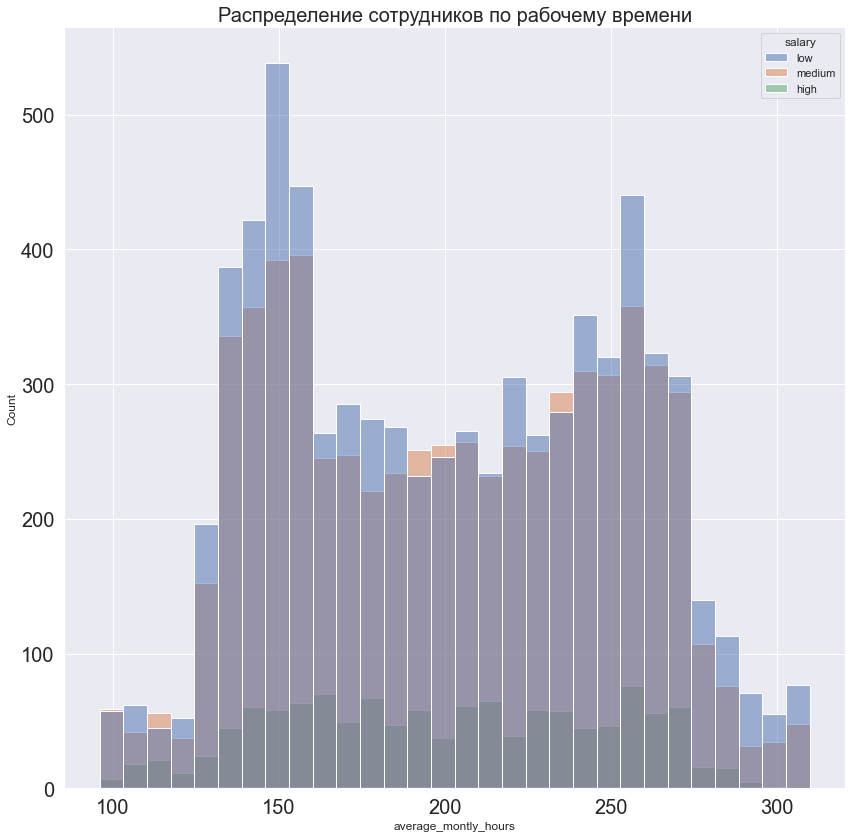

In [154]:
# надо глянуть форму распределений сотрудников
ax = sns.histplot(data=hr_frame, x="average_montly_hours", hue="salary")
ax.set_title("Распределение сотрудников по рабочему времени", fontsize=20)
set_plot_size(ax)

# по хорошему бутстрапом бы свести к нормальным, но тут будет без него

In [163]:
high_salary = hr_frame.loc[hr_frame["salary"] == "high"]
low_salary = hr_frame.loc[hr_frame["salary"] == "low"]

t, p = stats.ttest_ind(high_salary["average_montly_hours"], low_salary["average_montly_hours"])

alpha = 0.05 # стандартынй уровень значимости

if p > alpha:
    print(f"Время на работе не влияет на зарплату. p = {p}")
else:
    if t > 0:
        print(f"Сотрудники с более высокой зарплатой проводят в среднем больше времени на работе. p = {p}")
    else:
        print(f"Сотрудники с более высокой зарплатой проводят в среднем меньше времени на работе. p = {p}")

Время на работе не влияет на зарплату. p = 0.4661023478267259


## 8. Рассчет показателей среди уволившихся и неуволившихся сотрудников (по отдельности):
* Доля сотрудников с повышением за последние 5 лет
* Средняя степень удовлетворенности
* Среднее количество проектов

In [197]:
def show_indicators(frame: pd.DataFrame) -> None:
    up_frame = frame.loc[frame["promotion_last_5years"] > 0]
    up_percent = round(len(up_frame) / len(frame) * 100, 2)
    print(f"Процент сотрудников с повышением за последние 5 лет = {up_percent}%")

    average_satisfaction_level = round(frame["satisfaction_level"].mean(), 2)
    print(f"Средний уровень удовлетворенности = {average_satisfaction_level}")

    average_number_project = round(frame["number_project"].mean(), 2)
    print(f"Среднее число проектов = {average_number_project}")

# судя по всему уволились те, кого давно не повышали (и судя по числу проектов они сделали их больше)

### 8.1 Уволившиеся

In [199]:
left_frame = hr_frame.loc[hr_frame["left"] > 0]
show_indicators(left_frame)

Процент сотрудников с повышением за последние 5 лет = 0.53%
Средний уровень удовлетворенности = 0.44
Среднее число проектов = 3.86


### 8.2 Неуволившиеся

In [198]:
no_left_frame = hr_frame.loc[hr_frame["left"] == 0]
show_indicators(no_left_frame)

Процент сотрудников с повышением за последние 5 лет = 2.63%
Средний уровень удовлетворенности = 0.67
Среднее число проектов = 3.79


## 9. Построиние модели LDA, предсказывающую уволился ли сотрудник на основе имеющихся факторов (кроме department и salary)

In [225]:
x_frame_columns = (column for column in list(hr_frame) if column not in ("department", "salary", "salary_number", "left"))

# поделить фрейм на целевое значение и параметры
x_frame = hr_frame[x_frame_columns]
target_frame = hr_frame["left"]

# разделение данных на тестовые и тренировачные
x_train, x_test, y_train, y_test = train_test_split(x_frame, target_frame, test_size=0.25)

lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

#расчет точности. Самая простая метрика
f"точность предсказания модели = {accuracy_score(y_test, lda.predict(x_test))}"

'точность предсказания модели = 0.7669333333333334'